# Project milestone 4
# Detection of housing-health relationship


The aim of this project is to estimate the relation between housing quality and health status of a person. The project is an observational study based on a survey made by Mexican National Institute of Statistics and Geography. The health variables reported for each person will be used to define a single health variable which will be a score for each person's health status. We aim to use machine learning methods to do the classification and we will use regression models to predict this health score from the housing variables. Matching will be used to weed out the possible covariates. The motivation is to estimate the most important parameters of housing quality so that we can propose most cost-effective solutions that would increase the quality of health. The original paper is based on the analysis of influence of concrete floors on health quality, while here we would investigate some other parameters such as material used for building and whether there is a toilet or not in the household.

# Step 1: Import data

In [124]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

### Import data ###
#data_household = pd.read_csv('data_translated/household.csv')
data_house = pd.read_csv('data_translated/house.csv',low_memory=False)
data_person = pd.read_csv('data_translated/person.csv',low_memory=False)

In [125]:
#data_person_all = data_person.merge(data_house, left_on='House identifier', right_on='House identifier')
data_person_all = data_person.merge(data_house, left_on=['House_identifier'], right_on=['House_identifier'])

# Step 2: Exploratory Data Analysis

In [126]:
# our selected health variables
health_var = list(data_person_all.columns[34:57]) + [data_person_all.columns[26]]
data_person_all[health_var].describe()

,Wear_glasses,Difficulty_seeing,Wear_a_hearing_aid,Difficulty_hearing,Difficulty_hearing_without_noise,Difficulty_hearing_with_noise,Dificulty_to_walk,Use_a_walking_device,Walking_apparatus,Difficulty_walking_100_m,...,Medication_for_nervousness,Intensity_of_nervousness,Frequency_of_depression,Antidepressant_medications,Intensity_of_depression,Frequency_of_pain,Pain_intensity,Fatigue_frequency,Tired_time,Limiting_physical_or_mental_activity
count,208140,208140,208140,208140,208140,208140,208140,208140,208140,208140,...,208140,208140,208140,208140,208140,208140,208140,208140,208140,208140
unique,3,6,3,6,6,6,6,3,9,6,...,4,5,7,4,5,6,5,6,5,2
top,2,1,2,1,1,1,1,2,,1,...,2,,5,2,,1,,1,,
freq,146309,163575,197136,186322,190264,177606,175302,191991,201868,184590,...,178203,117286,126698,180272,152071,132028,157153,129517,154635,205250


In [127]:
# replacing " " and '9' values with proper Nan
data_person_all = data_person_all.replace(' ', np.nan)
data_person_all = data_person_all.replace('&', np.nan)
data_person_all = data_person_all.replace('9', np.nan)

In [128]:
# get an idea of what kind of values are present in the daset
#for i in range(len(data_person_all.columns)):
    #print(data_person_all[data_person_all.columns[i]].isna().sum())
    #print(data_person_all[data_person_all.columns[i]].value_counts())

In [129]:
# drop columns with more than 30% of NaN values
nulli = []
exc = []
thr = int(len(data_person_all)*0.3)
for i in range(len(list(data_person_all.columns))):
    nulli.append(data_person_all[list(data_person_all.columns)[i]].isnull().values.sum())
    if (nulli[i] > thr):
        exc.append(i)
data_person_all = data_person_all.drop(columns = [list(data_person_all.columns)[i] for i in exc], axis=1)
# drop columns considere not useful
data_person_all = data_person_all.drop(columns = ["Birthday", "Birth_month", "Basic_geostatistical_area"], axis=1)

In [130]:
# update health variable
health_var = [i for i in health_var if i in list(data_person_all.columns)]
len(health_var)

18

### Filter nan values

In [131]:
# fill nan values with median should be more robust than mean
data_person_all.fillna(data_person_all.median(),inplace = True)

### Choose apropriate data type for variables and categorize

In [132]:
# converting our data to integer type
for temp in data_person_all.columns:
    data_person_all[temp]=data_person_all[temp].astype(int)

### Creation of health variable

In [133]:
# from the dataset the binary column have encoding 2:True, 1:False
# for variables with more than one outcome they are in increasing order
weights = []
for temp in health_var:
    lista = []
    dic = dict(data_person_all[temp].value_counts())
    dic = sorted(dic.items(), reverse = True)
    
    som = 0
    for tup in dic:
        som += tup[1]
        lista.append(som/len(data_person_all))
    weights.append(lista)

In [134]:
# putting the weights in the dataset
for num,temp in enumerate(health_var):
    if (len(dic)==2):
        data_person_all[temp] = data_person_all[temp].replace(range(2,0,-1),weights[num])
    else:
        data_person_all[temp] = data_person_all[temp].replace(range(len(weights[num]),0,-1),weights[num])

In [135]:
#creating health variable
data_person_all["health"] = data_person_all.apply(lambda x: sum([x[i] for i in health_var]), axis=1)

<AxesSubplot:>

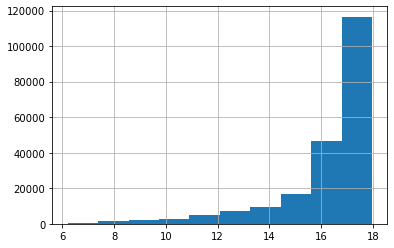

In [136]:
# distribution of "health" in the dataset
data_person_all["health"].hist()

# Step 3: Regression

### Fill response variables

In [137]:
data_person_all["health"].describe()

count    208140.000000
mean         16.055419
std           1.827860
min           6.205251
25%          15.885111
50%          16.972398
75%          16.972398
max          17.964452
Name: health, dtype: float64

In [138]:
# To run for all health_var or for health score
response='health'

### Pearson correlation

In [139]:
health_var.append('health')
covariates=list(data_person_all.columns)
covariates = [x for x in covariates if not x in health_var or covariates.remove(x)]

In [140]:
pearson_result=data_person_all[covariates].corrwith(data_person_all['health'], axis=0, method='pearson')
pearson_result=pearson_result.reindex(pearson_result.abs().sort_values().index)
pearson_result

Used_bedroom_kitchen                0.001203
Expansion_factor                    0.001747
Patio_space                         0.002833
Build_bedroom                      -0.003083
Total_households_in_the_dwelling    0.003631
                                      ...   
Worked_last_week                   -0.175280
Literacy                           -0.200052
School_attendance                  -0.212476
Identifier_of_the_person            0.250431
Age                                -0.501854
Length: 88, dtype: float64

### Fill model with all variables

In [141]:
# Do we filter here only important variables for example based on person correlation coef. for each response?

model='~Age'
start=data_person_all.columns.get_loc('Sex')
end=data_person_all.columns.get_loc('Worked_last_week')

for index,item in enumerate(data_person_all.columns):
    # Fill with person (control) variables
    if index >=start and index <=end:
        model=model+'+'+item
        #model=model+'+'+'C('+item+')'

    # To add also House variables
    elif index>end:
        break

In [142]:
formula=""
formula=response+model

In [143]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(1950)
mod= smf.ols(formula=response+model, data=data_person_all,missing='raise')
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 health   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     9188.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        10:21:44   Log-Likelihood:            -3.8282e+05
No. Observations:              208140   AIC:                         7.657e+05
Df Residuals:                  208129   BIC:                         7.658e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     17.7445      0.031    576.994      0.000      17.684      17.805
Age                           -0.0475      0.000   -220.583      0.000      -0.048      -0.047
Sex                           -0.1129      0.007    -16.330      0.000      -0.126      -0.099
Relationship                  -0.0376      0.002    -16.142      0.000      -0.042      -0.033
School_attendance              0.2277      0.009     24.271      0.000       0.209       0.246
Grade_level_of_instruction     0.0491      0.002     22.108      0.000       0.045       0.053
Level_of_instruction           0.1075      0.001     84.674      0.000       0.105       0.110
Home                          -0.0027      0.000     -7.089      0.000      -0.003      -0.002
Literacy                      -0.4719      0.015    -30.809      0.000      -0.502      -0.442
Marital_status                -0.0028      0.002     -1.360      0.174      -0.007       0.001
Worked_last_week              -0.2198      0.008    -28.395      0.000      -0.235      -0.205
==============================================================================
Omnibus:                    56964.720   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           181047.771
Skew:                          -1.400   Prob(JB):                         0.00
Kurtosis:                       6.611   Cond. No.                         403.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""